In [7]:
import os  
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 

data_dir = r'C:\Users\ASUS\Documents\2024\ML\UAS_Googlenet\train_data'

img_size = 224  
batch_size = 10
validation_split = 0.1

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='training',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

class_names = dataset.class_names
print("Class names:", class_names)

total_count = sum([len(files) for r, d, files in os.walk(data_dir)])  # Menghitung total file
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

print(f"Train Dataset Size: {len(train_ds)} batches")
print(f"Validation Dataset Size: {len(val_ds)} batches")


Found 300 files belonging to 3 classes.
Using 270 files for training.
Class names: ['Aloevera', 'Echeveria', 'Sedum']
Total Images: 302
Train Images: 272
Validation Images: 30
Found 300 files belonging to 3 classes.
Using 30 files for validation.
Train Dataset Size: 27 batches
Validation Dataset Size: 3 batches


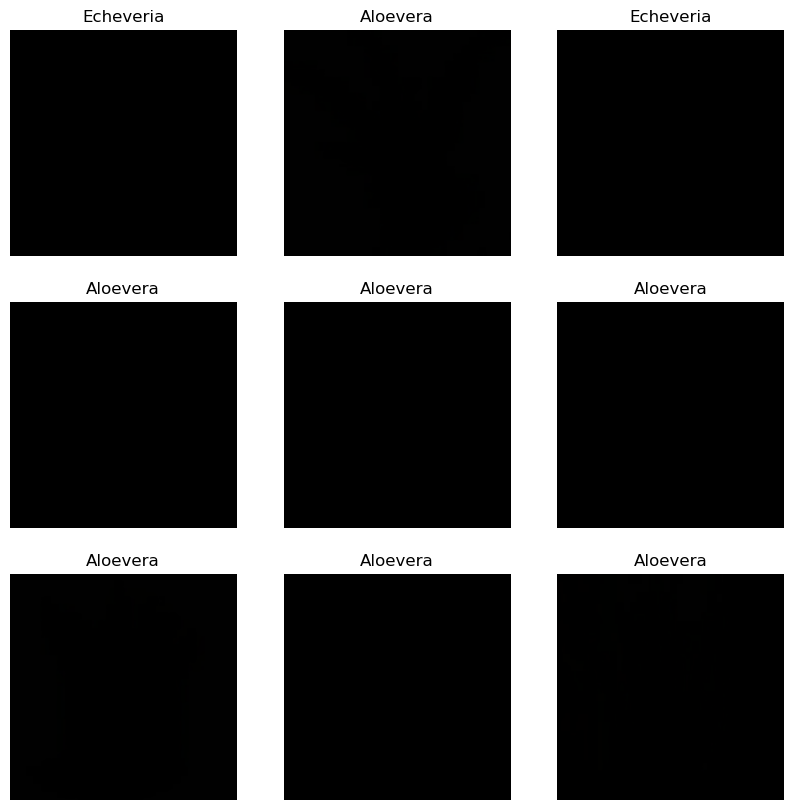

In [8]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))


for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(10, 224, 224, 3)


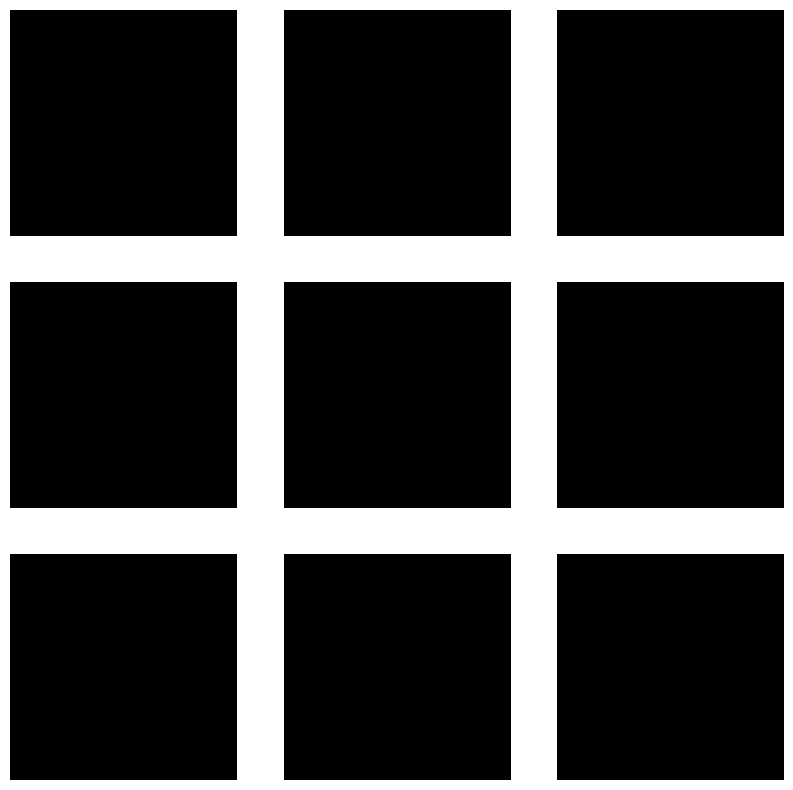

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)


data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

i = 0
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(69):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [11]:
import tensorflow as tf
import keras

import keras._tf_keras.keras.backend as K
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Conv2D
from keras._tf_keras.keras.layers import Flatten, MaxPool2D, AvgPool2D
from keras._tf_keras.keras.layers import Concatenate, Dropout

from keras._tf_keras.keras.models import load_model

def googlenet(input_shape, n_classes):
    
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
 
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        output = Concatenate()([t1, t2, t3, t4])
        return output
  
  
    input = Input(input_shape)
    
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
    
    x = AvgPool2D(3, strides=1)(x)
    x = Dropout(0.4)(x)
  
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input, output)
    return model

input_shape = 224, 224, 3   
n_classes = 3             

K.clear_session()
model = googlenet(input_shape, n_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 27, 27,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 27, 27,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 27, 27,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 27, 27,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 27, 27,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 27, 27,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 27, 27,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 27, 27,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 27, 27,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 27, 27,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 27, 27,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 6,050,355 (23.08 MB)

 Trainable params: 6,050,355 (23.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               mode='max')

history= model.fit(train_ds, 
                   epochs=54, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.7821 - loss: 0.5844 - val_accuracy: 0.7000 - val_loss: 0.6197
Epoch 2/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 609ms/step - accuracy: 0.8523 - loss: 0.3770 - val_accuracy: 0.8000 - val_loss: 0.5114
Epoch 3/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step - accuracy: 0.8157 - loss: 0.5401 - val_accuracy: 0.7667 - val_loss: 0.6942
Epoch 4/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 622ms/step - accuracy: 0.8206 - loss: 0.4379 - val_accuracy: 0.7333 - val_loss: 0.8055
Epoch 5/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 684ms/step - accuracy: 0.8660 - loss: 0.3993 - val_accuracy: 0.7667 - val_loss: 0.7100
Epoch 6/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.8725 - loss: 0.3647 - val_accuracy: 0.8000 - val_loss: 0.6876
Epoch 7/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 569ms/step - accuracy: 0.8435 - loss: 0.3481 - val_accuracy: 0.7667 - val_loss: 0.7660


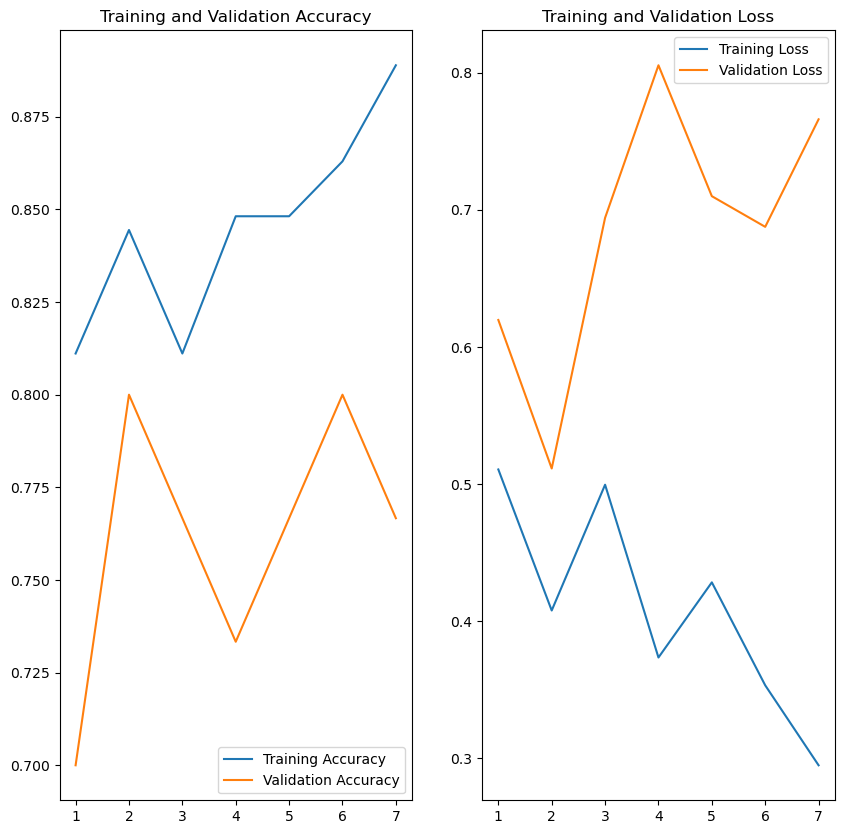

In [17]:
ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('googlenet.h5')

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'C:\Users\ASUS\Documents\2024\ML\UAS_Googlenet\googlenet.h5')  
class_names = ['Aloevera', 'Echeveria', 'Sedum']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        # Load and preprocess the image
        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_array /= 255.0  
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'C:\Users\ASUS\Documents\2024\ML\UAS_Googlenet\testing\Sedum\IMG_8077.JPG', save_path='sedum.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Prediksi: Sedum
Confidence: 45.32%
Prediksi: Sedum dengan confidence 45.32%. Gambar asli disimpan di sedum.jpg.


Found 30 files belonging to 3 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


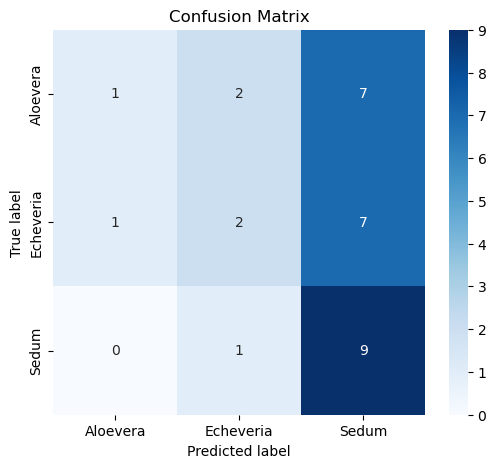

Confusion Matrix:
 [[1 2 7]
 [1 2 7]
 [0 1 9]]
Accuracy: 0.4
Precision: [0.5        0.4        0.39130435]
Recall: [0.1 0.2 0.9]
F1 Score: [0.16666667 0.26666667 0.54545455]


In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\ASUS\Documents\2024\ML\UAS_Googlenet\testing',
    labels='inferred',
    label_mode='categorical',  
    batch_size=10,
    image_size=(224, 224)
)

y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

precision = tf.where(tf.math.is_nan(precision), tf.zeros_like(precision), precision)
recall = tf.where(tf.math.is_nan(recall), tf.zeros_like(recall), recall)

f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = tf.where(tf.math.is_nan(f1_score), tf.zeros_like(f1_score), f1_score)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Aloevera", "Echeveria", "Sedum"], yticklabels=["Aloevera", "Echeveria", "Sedum"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Accuracy:", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
